# Time Series Prediction using LSTM with PyTorch in Python

link: https://stackabuse.com/time-series-prediction-using-lstm-with-pytorch-in-python/

In [1]:
import torch
import torch.nn as nn

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_formats = {'png', 'retina'}

from sklearn.preprocessing import MinMaxScaler

import warnings
warnings.filterwarnings('ignore')

## Load Data

In [2]:
flight_data = sns.load_dataset('flights')

In [3]:
print(flight_data.shape)
flight_data.head()

(144, 3)


,year,month,passengers
0,1949,January,112
1,1949,February,118
2,1949,March,132
3,1949,April,129
4,1949,May,121


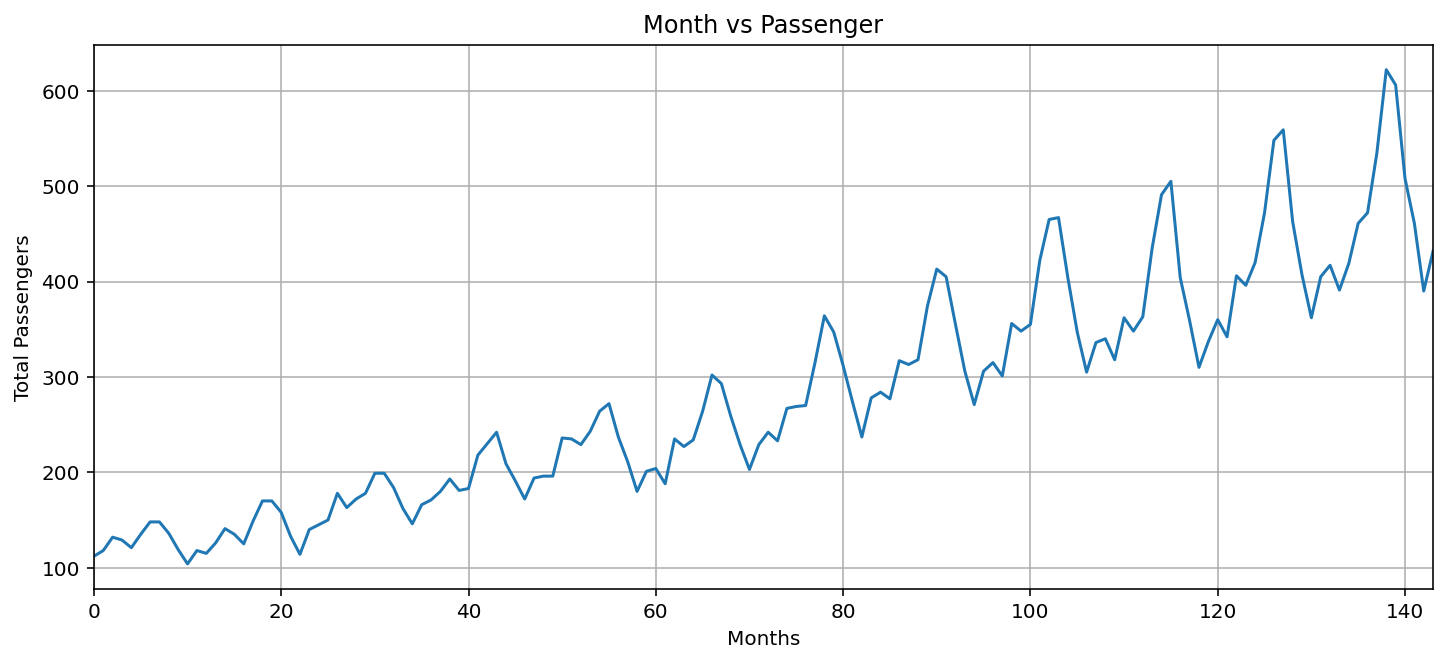

In [4]:
plt.figure(figsize=(12, 5))
plt.title('Month vs Passenger')
plt.ylabel('Total Passengers')
plt.xlabel('Months')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
plt.plot(flight_data['passengers'])
plt.show()

## Data Preprocessing

In [5]:
all_data = flight_data['passengers'].values.astype(float)

test_data_size = 12

train_data = all_data[:-test_data_size]
test_data = all_data[-test_data_size:]

print('train_data', len(train_data))
print('test_data ', len(test_data))

train_data 132
test_data  12


In [6]:
train_data

array([112., 118., 132., 129., 121., 135., 148., 148., 136., 119., 104.,
       118., 115., 126., 141., 135., 125., 149., 170., 170., 158., 133.,
       114., 140., 145., 150., 178., 163., 172., 178., 199., 199., 184.,
       162., 146., 166., 171., 180., 193., 181., 183., 218., 230., 242.,
       209., 191., 172., 194., 196., 196., 236., 235., 229., 243., 264.,
       272., 237., 211., 180., 201., 204., 188., 235., 227., 234., 264.,
       302., 293., 259., 229., 203., 229., 242., 233., 267., 269., 270.,
       315., 364., 347., 312., 274., 237., 278., 284., 277., 317., 313.,
       318., 374., 413., 405., 355., 306., 271., 306., 315., 301., 356.,
       348., 355., 422., 465., 467., 404., 347., 305., 336., 340., 318.,
       362., 348., 363., 435., 491., 505., 404., 359., 310., 337., 360.,
       342., 406., 396., 420., 472., 548., 559., 463., 407., 362., 405.])

In [7]:
test_data

array([417., 391., 419., 461., 472., 535., 622., 606., 508., 461., 390.,
       432.])

In [8]:
scaler = MinMaxScaler(feature_range=(-1, 1))
train_data_normalized = scaler.fit_transform(train_data.reshape(-1, 1))
train_data_normalized = torch.FloatTensor(train_data_normalized).view(-1)

In [9]:
print(train_data_normalized[:5])
print(train_data_normalized[-5:])

tensor([-0.9648, -0.9385, -0.8769, -0.8901, -0.9253])
tensor([1.0000, 0.5780, 0.3319, 0.1341, 0.3231])


In [10]:
def create_inout_sequences(input_data, window_size):
    inout_seq = []
    L = len(input_data)
    for i in range(L-window_size):
        seq = input_data[i:i+window_size]
        label = input_data[i+window_size:i+window_size+1]
        inout_seq.append((seq ,label))
    return inout_seq

train_window = 12
train_inout_seq = create_inout_sequences(train_data_normalized, train_window)

In [11]:
train_inout_seq[:5]

[(tensor([-0.9648, -0.9385, -0.8769, -0.8901, -0.9253, -0.8637, -0.8066, -0.8066,
          -0.8593, -0.9341, -1.0000, -0.9385]),
  tensor([-0.9516])),
 (tensor([-0.9385, -0.8769, -0.8901, -0.9253, -0.8637, -0.8066, -0.8066, -0.8593,
          -0.9341, -1.0000, -0.9385, -0.9516]),
  tensor([-0.9033])),
 (tensor([-0.8769, -0.8901, -0.9253, -0.8637, -0.8066, -0.8066, -0.8593, -0.9341,
          -1.0000, -0.9385, -0.9516, -0.9033]),
  tensor([-0.8374])),
 (tensor([-0.8901, -0.9253, -0.8637, -0.8066, -0.8066, -0.8593, -0.9341, -1.0000,
          -0.9385, -0.9516, -0.9033, -0.8374]),
  tensor([-0.8637])),
 (tensor([-0.9253, -0.8637, -0.8066, -0.8066, -0.8593, -0.9341, -1.0000, -0.9385,
          -0.9516, -0.9033, -0.8374, -0.8637]),
  tensor([-0.9077]))]

## Creating LSTM Model

In [44]:
class LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=100, output_size=1):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size
        self.lstm_1 = nn.LSTM(input_size, hidden_layer_size)
        self.lstm_2 = nn.LSTM(hidden_layer_size, hidden_layer_size)
        self.linear = nn.Linear(hidden_layer_size, output_size)
        self.hidden_cell = (torch.zeros(1, 1, self.hidden_layer_size),
                            torch.zeros(1, 1, self.hidden_layer_size))
        
    def forward(self, input_seq):
        lstm_out, self.hidden_cell = self.lstm_1(
            input_seq.view(len(input_seq), 1, -1), self.hidden_cell)
        
        predictions = self.linear(lstm_out.view(len(input_seq), -1))
        return predictions[-1]

In [45]:
model = LSTM()
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [46]:
print(model)

LSTM(
  (lstm_1): LSTM(1, 100)
  (lstm_2): LSTM(100, 100)
  (linear): Linear(in_features=100, out_features=1, bias=True)
)


## Training the Model

In [47]:
epochs = 100

for i in range(epochs):
    for seq, labels in train_inout_seq:
        optimizer.zero_grad()
        model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),
                            torch.zeros(1, 1, model.hidden_layer_size))
        
        y_pred = model(seq)
        
        single_loss = loss_function(y_pred, labels)
        single_loss.backward()
        optimizer.step()
    
    if i%25 == 0:
        print(f'epoch: {i:3} loss: {single_loss.item():10.8f}')

print(f'epoch: {i:3} loss: {single_loss.item():10.10f}')

epoch:   0 loss: 0.10592797
epoch:  25 loss: 0.01306314
epoch:  50 loss: 0.00110141
epoch:  75 loss: 0.01391664
epoch:  99 loss: 0.0000001781


## Making Predictions

In [16]:
fut_pred = 12

test_inputs = train_data_normalized[-train_window:].tolist()
print(test_inputs)

[0.12527473270893097, 0.04615384712815285, 0.3274725377559662, 0.2835164964199066, 0.3890109956264496, 0.6175824403762817, 0.9516483545303345, 1.0, 0.5780220031738281, 0.33186814188957214, 0.13406594097614288, 0.32307693362236023]


In [17]:
for i in range(fut_pred):
    seq = torch.FloatTensor(test_inputs)
    with torch.no_grad():
        model.hidden = (torch.zeros(1, 1, model.hidden_layer_size),
                        torch.zeros(1, 1, model.hidden_layer_size))
        test_inputs.append(model(seq).item())

In [18]:
test_inputs[fut_pred:]

[0.9904282689094543,
 1.2080166339874268,
 1.3506110906600952,
 1.4819514751434326,
 1.5962504148483276,
 1.6961145401000977,
 1.7780933380126953,
 1.8441909551620483,
 1.8966937065124512,
 1.939513921737671,
 1.9762718677520752,
 2.0103166103363037]

In [19]:
actual_predictions = scaler.inverse_transform(np.array(test_inputs[train_window:] ).reshape(-1, 1))
print(actual_predictions)

[[556.82243118]
 [606.32378423]
 [638.76402313]
 [668.6439606 ]
 [694.64696938]
 [717.36605787]
 [736.0162344 ]
 [751.0534423 ]
 [762.99781823]
 [772.7394172 ]
 [781.10184991]
 [788.84702885]]


In [20]:
x = np.arange(132, 144, 1)
print(x)

[132 133 134 135 136 137 138 139 140 141 142 143]


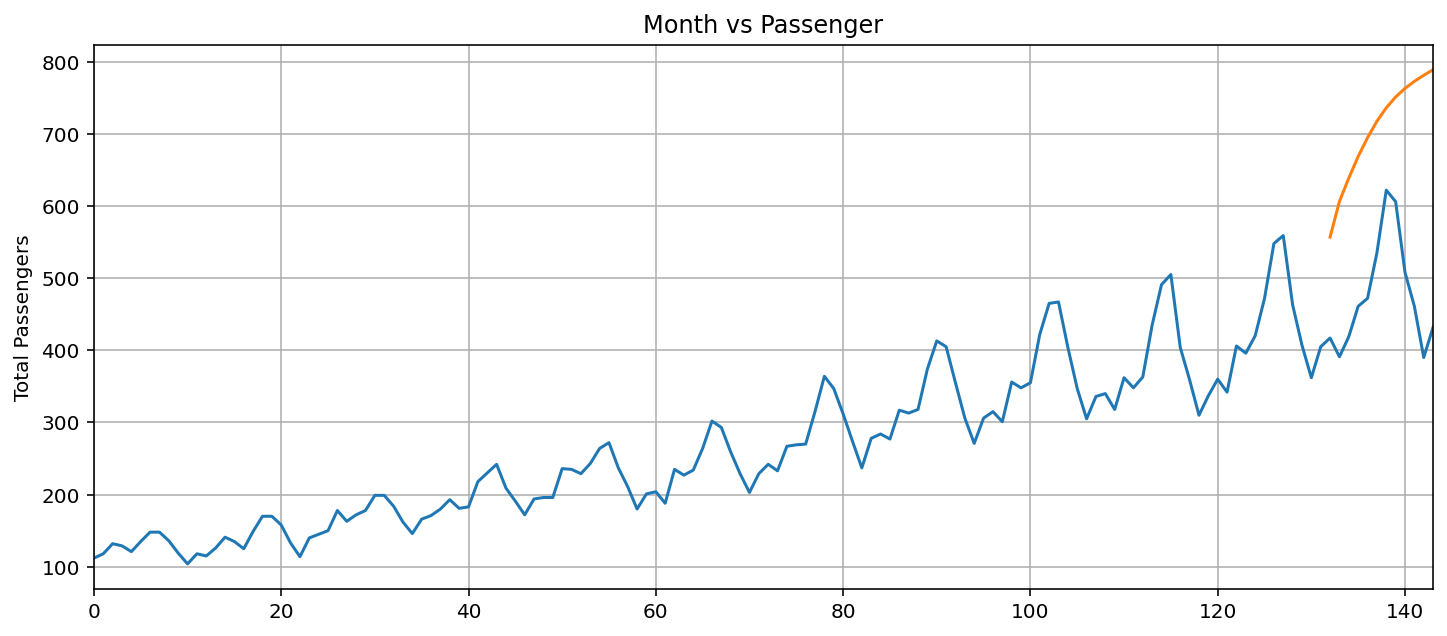

In [21]:
plt.figure(figsize=(12, 5))
plt.title('Month vs Passenger')
plt.ylabel('Total Passengers')
plt.grid(True)
plt.autoscale(axis='x', tight=True)
plt.plot(flight_data['passengers'])
plt.plot(x, actual_predictions)
plt.show()

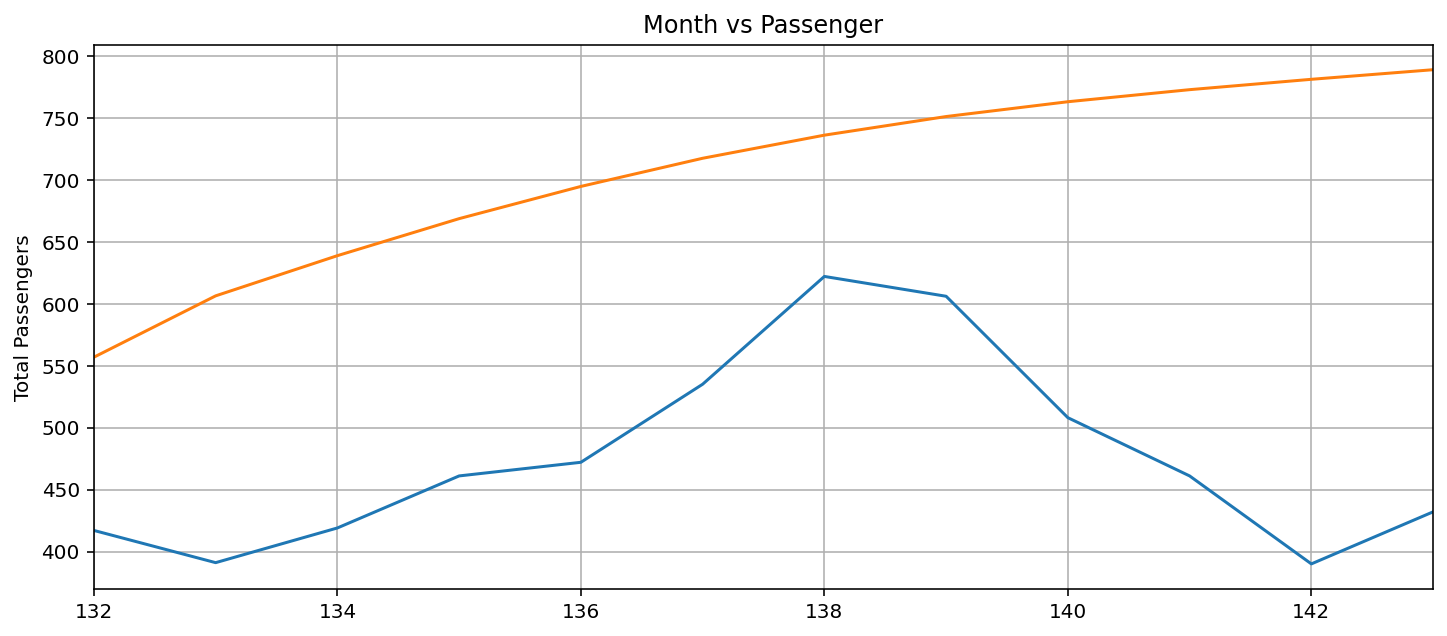

In [22]:
plt.figure(figsize=(12, 5))
plt.title('Month vs Passenger')
plt.ylabel('Total Passengers')
plt.grid(True)
plt.autoscale(axis='x', tight=True)
plt.plot(flight_data['passengers'][-train_window:])
plt.plot(x, actual_predictions)
plt.show()